# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [38]:
!pip install grad-cam
!pip install medmnist

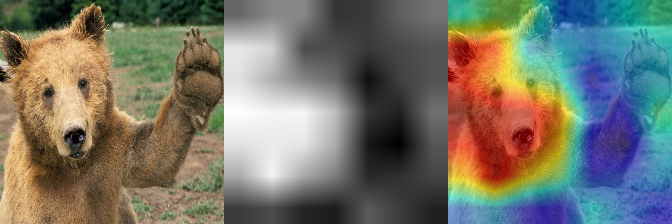

In [77]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.005073414649814367
The visualization of the pertubated image for the metric:


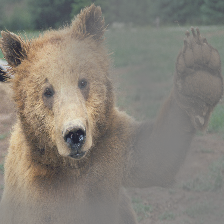

In [78]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|██████████| 64/64 [00:04<00:00, 14.93it/s]


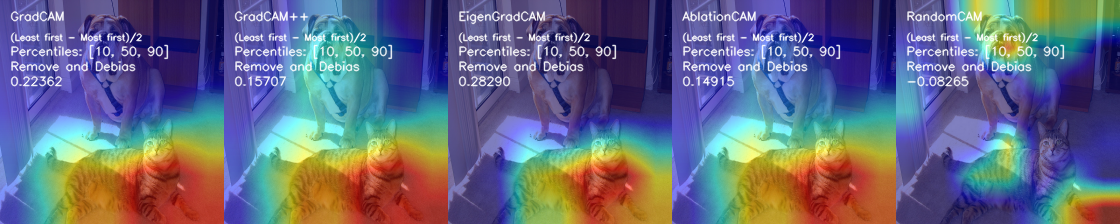

In [79]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
#benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

#target_layers = [model.layer4[-2]]
benchmark(input_tensor, target_layers)
#benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [235]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, random_split
from torchvision import models

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of
# them are compatible with the standard torchvision models
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
print(info)
# labels
# 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set_raw = DataClass(split='test', transform=transforms.ToTensor(), target_transform=Lambda(lambda y: y[0]), download=True)

#print(f"Number of training samples: {len(train_set)}")
#print(f"Number of validation samples: {len(val_set)}")
#print(f"Number of testing samples: {len(test_set)}")

# You are expected to create the appropriate dataloaders to be used for training, testing and validation
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###

model = models.resnet50(pretrained=True)
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
test_loader_raw = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False)

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'task': 'multi-class', 'label': {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}, 'n_channels': 3, 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421}, 'license': 'CC BY 4.0'}

### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

Class of input image: 1


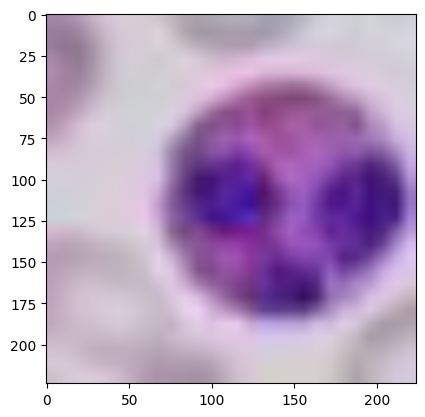

In [246]:
# benchmark and visualize_score function from above but suited for medical images
from torchvision.transforms import ToPILImage
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_image = test_loader_raw.dataset[4][0].unsqueeze(0).to(device)
# print class of input image
print(f"Class of input image: {test_loader.dataset[4][1]}")

resize_transform = transforms.Resize((224, 224))
resized_input_image = resize_transform(input_image)

input_image_np = np.array(ToPILImage()(resized_input_image[0]))
input_image_np = np.float32(input_image_np) / 255

#plot the image
plt.imshow(input_image_np)
plt.show()

target_layers = [model.layer4]

# Showing the metrics on top of the CAM :
def custom_visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def custom_benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = [np.uint8(255*input_image_np)]
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]

        visualization = show_cam_on_image(input_image_np, attribution, use_rgb=True)
        visualization = custom_visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


Using device: cuda


Training-loop:   0%|          | 0/187 [00:00<?, ?it/s]

Validation-loop: 100%|██████████| 27/27 [00:01<00:00, 22.71it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.07it/s]


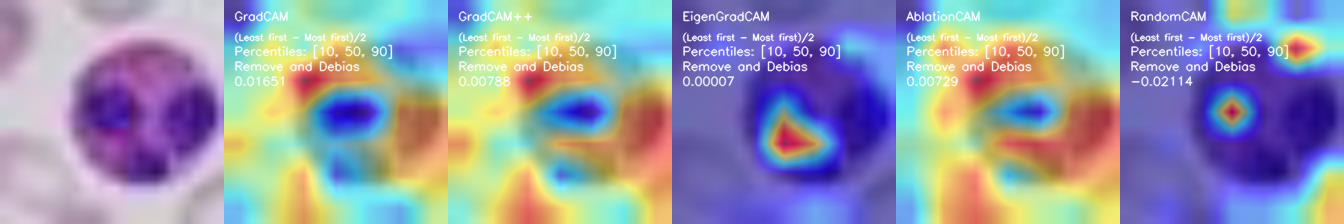

Train Epoch: 1 Loss: 0.280936 Validation loss: 0.238399 Acc: 90.742131 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 31.74it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.05it/s]


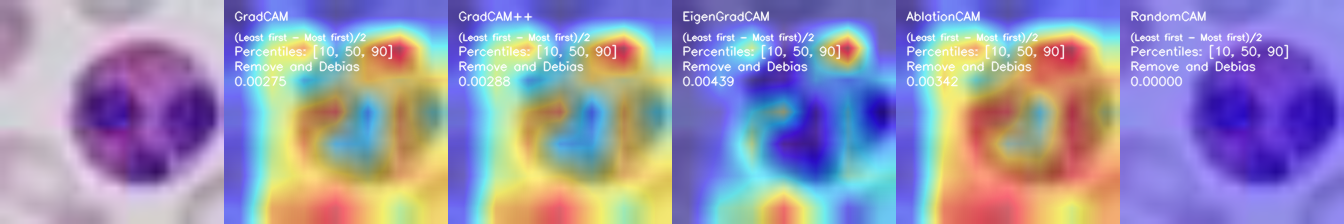

Train Epoch: 2 Loss: 1.628485 Validation loss: 0.597097 Acc: 50.592185 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 32.41it/s]


Grad-cam testing


100%|██████████| 64/64 [00:05<00:00, 12.67it/s]


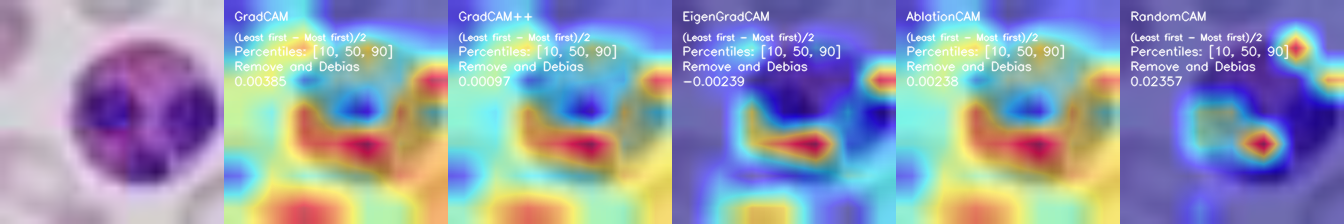

Train Epoch: 3 Loss: 0.353821 Validation loss: 0.477906 Acc: 87.480706 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 33.01it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.02it/s]


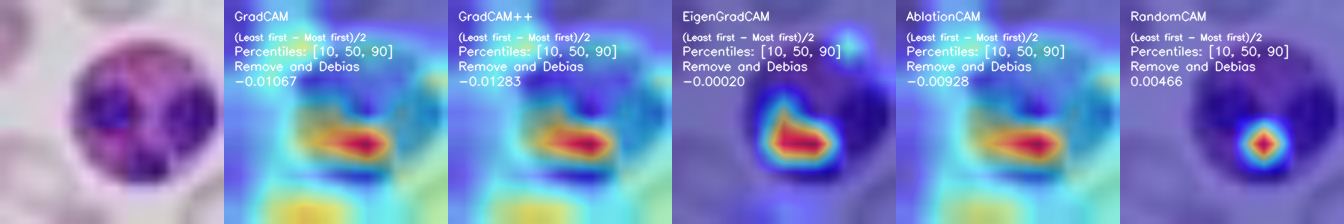

Train Epoch: 4 Loss: 0.253434 Validation loss: 0.219457 Acc: 91.241948 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 29.13it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 12.83it/s]


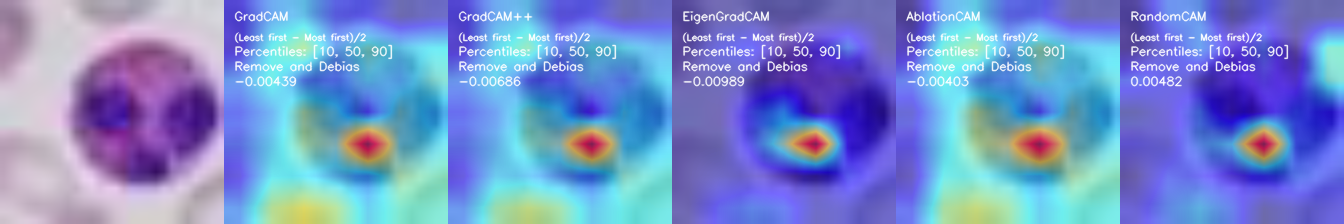

Train Epoch: 5 Loss: 0.173566 Validation loss: 0.244559 Acc: 93.904655 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 32.84it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.09it/s]


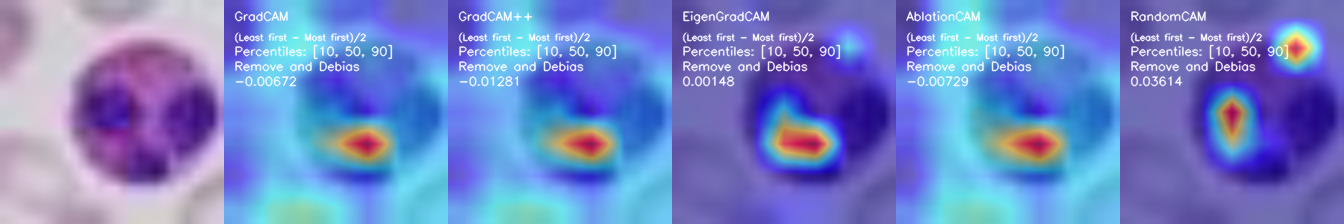

Train Epoch: 6 Loss: 0.158900 Validation loss: 0.241992 Acc: 94.422703 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 31.13it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.31it/s]


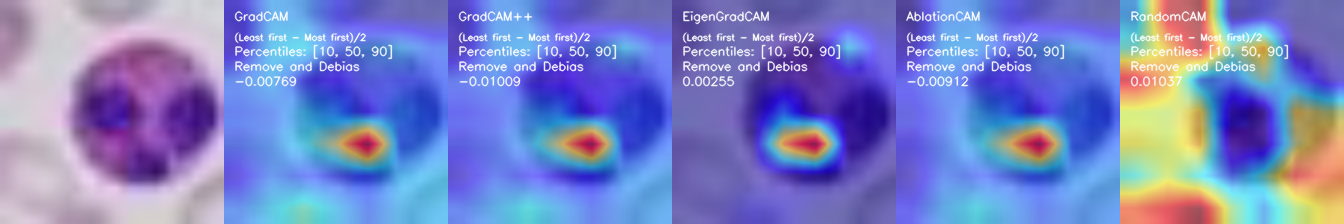

Train Epoch: 7 Loss: 0.136087 Validation loss: 0.265801 Acc: 95.183064 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 31.52it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.03it/s]


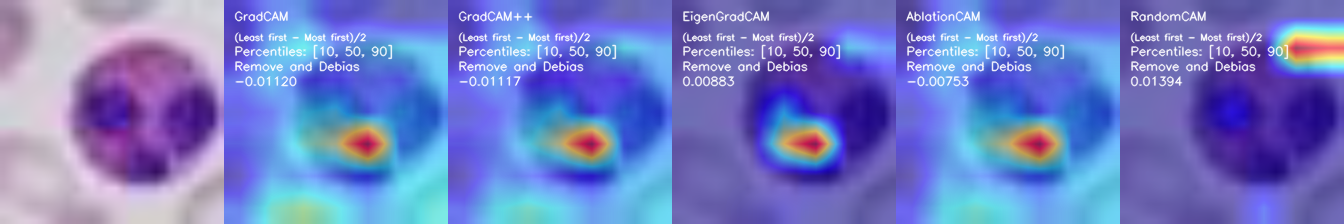

Train Epoch: 8 Loss: 0.126145 Validation loss: 0.196868 Acc: 95.904381 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 31.44it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.28it/s]


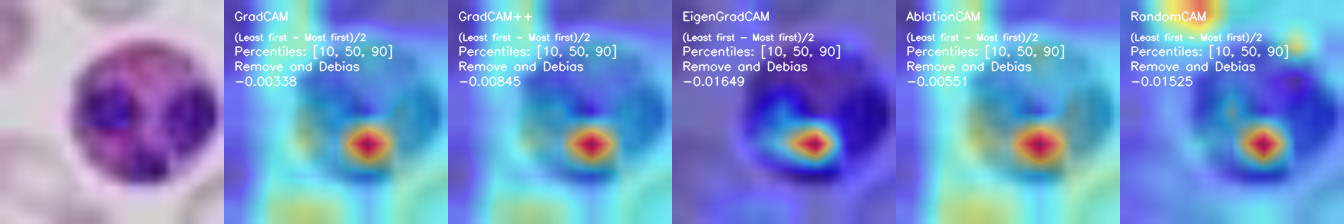

Train Epoch: 9 Loss: 0.092993 Validation loss: 0.191584 Acc: 96.865277 


Validation-loop: 100%|██████████| 27/27 [00:00<00:00, 31.43it/s]


Grad-cam testing


100%|██████████| 64/64 [00:04<00:00, 13.40it/s]


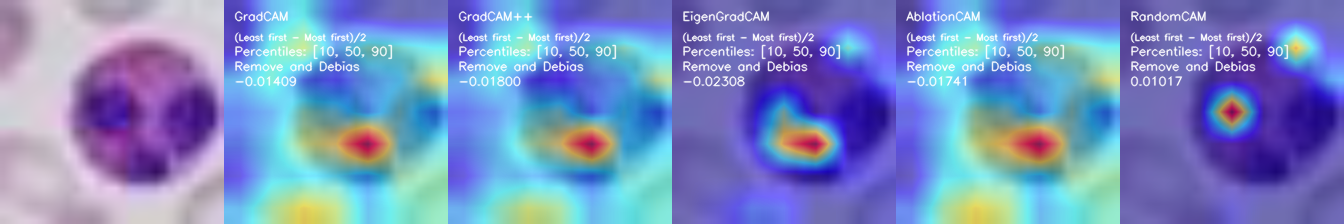

Train Epoch: 10 Loss: 0.095992 Validation loss: 0.269640 Acc: 96.844464 


In [247]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from IPython.display import display

# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []

        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            loss = criterion(output, target)

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        with torch.no_grad():
                for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                    optimizer.zero_grad()
                    data, target = data.to(device), target.to(device).long()
                    pred = model(data)
                    loss = criterion(pred, target)
                    valid_losses.append(loss.item())

        # We suggest you modify this code to run the continuous explanations
        print(f"Grad-cam testing")
        target_layers = [model.layer4]

        # load input image from bloodmnist dataloader
        input_image = train_loader.dataset[0][0].unsqueeze(0).to(device)
        resize_transform = transforms.Resize((224, 224))
        resized_input_image = resize_transform(input_image)

        result_image = custom_benchmark(resized_input_image, target_layers, category=1)
        display(result_image)
        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = train(device, model, train_loader, epochs=10, learning_rate=0.001)

# save model
saved_models = model
torch.save(saved_models, 'saved_models.pt')

In [18]:
def test(device, model, data_loader, mean=0.5432, std=0.2731):
    model.eval()
    preds = []
    pred_list = []


    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = images.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"Grad-cam testing")
    target_layers = None
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        

    return np.concatenate(pred_list)

IndentationError: expected an indented block after 'with' statement on line 26 (389538701.py, line 29)